In [2]:

import zipfile


In [22]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

## Import Data

In [1]:
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [1]:
! which wget


wget not found


In [3]:
with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')

NameError: name 'zipfile' is not defined

In [30]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

In [191]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


## Clean Data and Filter For Needed Info

In [31]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [32]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
0,138860,110,245000,08/21/2014
4,213043,120,560000,12/20/2019
5,951120,900,85000,04/20/1989
7,122209,9002,5755000,04/25/2001
8,122209,9001,5755000,04/25/2001


In [33]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'SqFtLot', 'WfntLocation', 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']]
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616089 entries, 0 to 616088
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Major           616089 non-null  int64 
 1   Minor           616089 non-null  int64 
 2   SqFtLot         616089 non-null  int64 
 3   WfntLocation    616089 non-null  int64 
 4   TrafficNoise    616089 non-null  int64 
 5   AirportNoise    616089 non-null  int64 
 6   PowerLines      616089 non-null  object
 7   OtherNuisances  616089 non-null  object
dtypes: int64(6), object(2)
memory usage: 37.6+ MB


In [34]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'NbrLivingUnits', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [35]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]

In [36]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


In [37]:
# Join all the tables on Major, Minor
# Have duplicate buildings sold at different dates. Need to only keep latest dates
merged_tables = real_property_sales.merge(parcel).merge(residential_building).drop_duplicates()
# Change dates to date time format
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [38]:
#Keeping only the most recent Sale_Price
buildings_df = merged_tables.sort_values('DocumentDate').drop_duplicates(['Major', 'Minor'],keep='first')

In [39]:
df_test = buildings_df.sort_values('DocumentDate')
df_test

,Major,Minor,SalePrice,DocumentDate,SqFtLot,WfntLocation,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrLivingUnits,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,Has_Porch
705940,514510,250,125000,1934-11-11,7041,0,0,0,N,N,1,910,0,0,0
443490,718680,30,600,1954-03-11,9345,0,0,0,N,N,1,1380,40,0,1
653999,245840,30,9500,1955-04-15,6300,0,1,0,N,N,1,820,0,0,0
962419,222470,151,12250,1959-10-10,11115,0,1,0,N,N,1,2090,0,0,0
235295,503180,251,2300,1960-09-27,19064,3,0,0,N,N,1,1140,40,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900477,241990,45,642000,2020-09-08,11054,0,0,0,N,N,1,1510,0,0,0
366504,327530,150,393000,2020-09-09,9500,0,0,0,N,N,1,1250,110,0,1
925600,797260,2865,590000,2020-09-09,10275,0,0,0,N,N,1,1660,40,0,1
960304,330070,280,535000,2020-09-09,4000,0,0,0,N,N,1,700,0,0,0


In [77]:
# Check x if have the relevant data to answer question
# [x]Higher square footage increases home sale price1, 2
# [x]Having a porch increases home sale price3, 4
# [x]Having a beachfront or lakefront increases home sale price5
# [x]The house filling a higher proportion of the overall lot decreases home sale price6
# [x]The cost per square foot is lower in duplexes than in single-family homes7
# [x]The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price1, 5

## Graphical EDA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

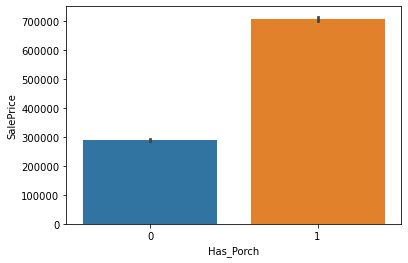

In [14]:
sns.barplot(df['Has_Porch'], df['SalePrice']);




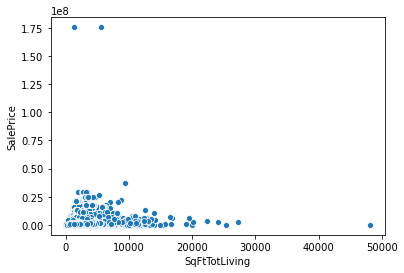

In [15]:
sns.scatterplot(df['SqFtTotLiving'], df['SalePrice']);




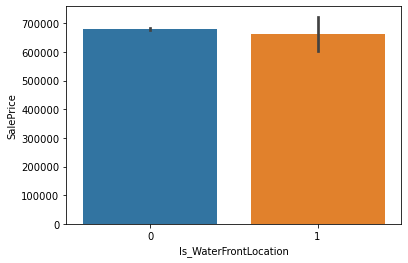

In [64]:
sns.barplot(df['Is_WaterFrontLocation'], df['SalePrice']);

In [193]:
df = pd.read_csv('../../data/clean/KingCountyHousingData.csv')
df.head()


,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,TrafficNoise,PowerLines,OtherNuisances,Has_Nuisance,WaterFrontLocation,Is_WaterFrontLocation,Has_Porch,PropType,NbrLivingUnits
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,0,0,0,None,0,1,R,1
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,0,0,0,None,0,1,R,1
2,2,100,42,NaN,2019-10-29,485500,6002,2134,No Nuisances,0,0,0,0,None,0,1,R,1
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,0,0,0,None,0,0,R,1
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,0,0,1,None,0,0,R,1


In [ ]:
#df.hist(figsize=(18,15), bins='auto');

In [200]:
df_water_dummie =pd.get_dummies(df['WaterFrontLocation'])
df_water_dummie.drop('None', axis= 1, inplace=True)
df_water_dummie['SqFtTotLiving'] = df.SqFtTotLiving
df_water_dummie

,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal,SqFtTotLiving
0,0,0,0,0,0,0,0,0,2240
1,0,0,0,0,0,0,0,0,1200
2,0,0,0,0,0,0,0,0,2134
3,0,0,0,0,0,0,0,0,3500
4,0,0,0,0,0,0,0,0,2170
...,...,...,...,...,...,...,...,...,...
27723,0,0,0,0,0,0,0,0,1090
27724,0,0,0,0,0,0,0,0,1560
27725,0,0,0,0,0,0,0,0,790
27726,0,0,0,0,0,0,0,0,3830


In [195]:
from sklearn.linear_model import LinearRegression

In [201]:
lr = LinearRegression()
lr.fit(df_water_dummie, df['SalePrice'])
#lr.__dict__

LinearRegression()

In [202]:
lr.score(df_water_dummie, df['SalePrice'])

0.3938249126710396

In [203]:
lr.coef_

array([-8.64230198e+03,  1.82451159e+06,  3.66917232e+05,  2.08094891e+06,
        3.48825330e+04,  4.17368854e+05,  4.61416527e+04,  8.82451221e+05,
        3.35148305e+02])

In [204]:
for col, coef in zip(list(df_water_dummie), lr.coef_):
    print(col,coef)


Duwamish -8642.301983919653
Lake Sammamish 1824511.594837179
Lake Union 366917.2320589037
Lake Washington 2080948.9118918083
Other lake 34882.533010235835
Puget Sound 417368.8540398439
River or slough 46141.65265221202
Ship Canal 882451.2212115225
SqFtTotLiving 335.14830484709955


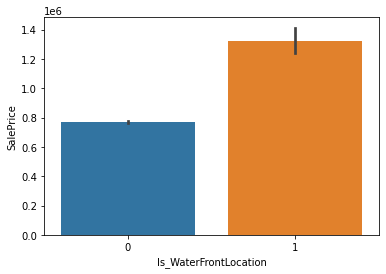

In [97]:
sns.barplot(df['Is_WaterFrontLocation'], df['SalePrice']);

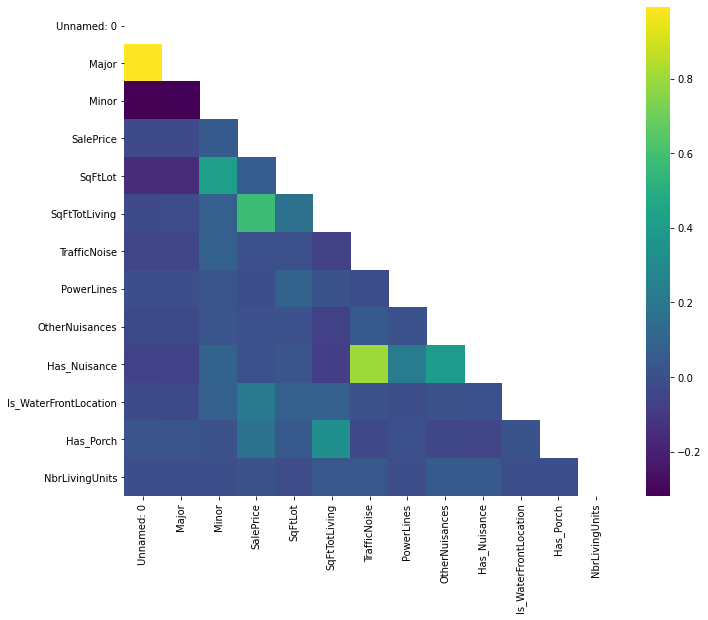

In [205]:
corr = df.corr()
# The mask is not necessary, but corr() has duplicate values on either side of the diagonal
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

## EDA simple models


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
%matplotlib inline

### FSM_Model 1

In [113]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving']

In [115]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.603e+04
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:04:10   Log-Likelihood:            -4.1190e+05
No. Observations:               28824   AIC:                         8.238e+05
Df Residuals:                   28822   BIC:                         8.238e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.106e+05   5757.098     19.217      0.000    9.93e+04    1.22e+05
SqFtTotLiving   306.1794      2.419    126.597      0.000     301.439     310.920
==============================================================================
Omnibus:                    13104.282   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110455.449
Skew:                           1.996   Prob(JB):                         0.00
Kurtosis:                      11.720   Cond. No.                     5.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### FSM_Model 2

In [111]:
outcome = 'SalePrice'
x_cols = ['Has_Porch']

In [112]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1287.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          9.26e-276
Time:                        13:01:19   Log-Likelihood:            -4.1765e+05
No. Observations:               28824   AIC:                         8.353e+05
Df Residuals:                   28822   BIC:                         8.353e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.667e+05   4202.924    158.627      0.000    6.58e+05    6.75e+05
Has_Porch    2.02e+05   5630.090     35.873      0.000    1.91e+05    2.13e+05
==============================================================================
Omnibus:                    13917.537   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91641.326
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      10.480   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 3

In [116]:
outcome = 'SalePrice'
x_cols = ['Is_WaterFrontLocation']

In [117]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     543.6
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          3.96e-119
Time:                        13:06:08   Log-Likelihood:            -4.1801e+05
No. Observations:               28824   AIC:                         8.360e+05
Df Residuals:                   28822   BIC:                         8.360e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.713e+05   2852.292    270.404      0.000    7.66e+05    7.77e+05
Is_WaterFrontLocation  5.542e+05   2.38e+04     23.315      0.000    5.08e+05    6.01e+05
==============================================================================
Omnibus:                    13630.220   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85827.233
Skew:                           2.217   Prob(JB):                         0.00
Kurtosis:                      10.198   Cond. No.                         8.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 4

In [120]:
outcome = 'SalePrice'
x_cols = ['Has_Nuisance']

In [121]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.043
Date:                Tue, 29 Sep 2020   Prob (F-statistic):              0.307
Time:                        13:09:15   Log-Likelihood:            -4.1827e+05
No. Observations:               28824   AIC:                         8.366e+05
Df Residuals:                   28822   BIC:                         8.366e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     7.779e+05   3137.880    247.915      0.000    7.72e+05    7.84e+05
Has_Nuisance  7765.3750   7603.559      1.021      0.307   -7137.952    2.27e+04
==============================================================================
Omnibus:                    14136.291   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92644.887
Skew:                           2.303   Prob(JB):                         0.00
Kurtosis:                      10.478   Cond. No.                         2.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 5

In [124]:
outcome = 'SalePrice'
x_cols = ['SqFtLot']

In [125]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     147.2
Date:                Tue, 29 Sep 2020   Prob (F-statistic):           8.65e-34
Time:                        13:12:40   Log-Likelihood:            -4.1820e+05
No. Observations:               28824   AIC:                         8.364e+05
Df Residuals:                   28822   BIC:                         8.364e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.606e+05   3239.580    234.779      0.000    7.54e+05    7.67e+05
SqFtLot        1.4735      0.121     12.132      0.000       1.235       1.712
==============================================================================
Omnibus:                    14076.440   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92185.738
Skew:                           2.291   Prob(JB):                         0.00
Kurtosis:                      10.467   Cond. No.                     3.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multilinear Models


### ML_Model 1

In [127]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch' ]

In [154]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model1 = ols(formula=formula, data=df).fit()
ml_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5639.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:38:14   Log-Likelihood:            -4.1162e+05
No. Observations:               28824   AIC:                         8.232e+05
Df Residuals:                   28820   BIC:                         8.233e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.079e+05   5763.462     18.716      0.000    9.66e+04    1.19e+05
SqFtTotLiving           302.5124      2.543    118.947      0.000     297.528     307.497
Has_Porch              7563.4853   4847.244      1.560      0.119   -1937.338    1.71e+04
Is_WaterFrontLocation  4.555e+05   1.91e+04     23.894      0.000    4.18e+05    4.93e+05
==============================================================================
Omnibus:                    12545.159   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102534.109
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      11.422   Cond. No.                     2.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 2

In [141]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch', 'Is_WaterFrontLocation']

In [155]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model2 = ols(formula=formula, data=df).fit()
ml_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5639.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:38:21   Log-Likelihood:            -4.1162e+05
No. Observations:               28824   AIC:                         8.232e+05
Df Residuals:                   28820   BIC:                         8.233e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.079e+05   5763.462     18.716      0.000    9.66e+04    1.19e+05
SqFtTotLiving           302.5124      2.543    118.947      0.000     297.528     307.497
Has_Porch              7563.4853   4847.244      1.560      0.119   -1937.338    1.71e+04
Is_WaterFrontLocation  4.555e+05   1.91e+04     23.894      0.000    4.18e+05    4.93e+05
==============================================================================
Omnibus:                    12545.159   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102534.109
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      11.422   Cond. No.                     2.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 3

In [ ]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch', 'Is_WaterFrontLocation']

In [ ]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model2 = ols(formula=formula, data=df).fit()
ml_model2.summary()

# Multicollinearity check

In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [133]:
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('SqFtTotLiving', 2.504714110013889),
 ('Has_Porch', 2.4887040096589823),
 ('Is_WaterFrontLocation', 1.0161910157346665)]

In [ ]:
#values are under 5 vif, no collinearity as is

In [153]:
#testing with Rainbow test

rainbow_statistic, rainbow_p_value = linear_rainbow(ml_model2)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9417309989928961
Rainbow p-value: 0.9998427534129499


# Normality Check/Q-Q plot


In [60]:
import statsmodels.api as sm
import scipy.stats as stats

dist=stats.norm
fit=True

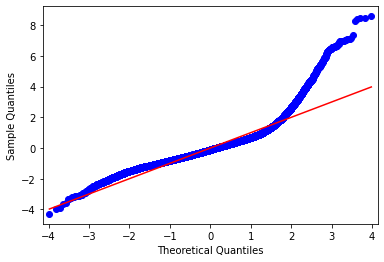

In [159]:
fig = sm.graphics.qqplot(ml_model2.resid, line='s',dist=stats.norm, fit=True)

# Homoscedasticity Check

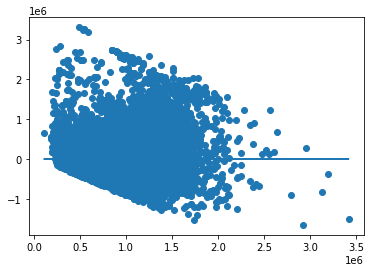

In [158]:
plt.scatter(ml_model2.predict(df[x_cols]), ml_model2.resid)
plt.plot(ml_model2.predict(df[x_cols]), [0 for i in range(len(df))]);